In [1]:
import json

from modeling import get_order, Runner
from plotnine import *

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from sklearn.datasets import load_wine
wine = load_wine(as_frame = True).frame
wine["target2"] = (wine.target==1)
wine.loc[:,"row_id"] = wine.index

In [9]:
config = {
            "validation": {
                "splitter": {
                    "id": "KFold",
                    "params": {
                        "n_splits": 2
                    }
                },
                "evalulation": {
                    "metrics": ["sklearn:mean_squared_error",
                                "sklearn:mean_absolute_error"]
                }
            },
            "model": {
                "id": "xgboost",
                "params": {
                    "objective": "reg:squarederror",
                    "eval_metric": "rmse",
                    "num_boost_round": [500, 1000],
                    "eta": 0.3,
                    "max_depth": [4, 6, 8]
                }
            },
            "data": {
                "target": "alcohol",
                "features": {
                    "asis": ["malic_acid", "ash", "alcalinity_of_ash", "magnesium",
                        "total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins",
                         "color_intensity", "hue", "od280/od315_of_diluted_wines", "proline"]
                    }
                }
            }

In [14]:
order = get_order(df = wine, config = config)

runner = Runner(workers = 4)
runner.run(order = order)

process started
adding result
adding result
adding result
adding result
adding result
adding result


In [15]:
evaldf = order.get_results()['eval']
evaldf.head()

,task_id,param_id,split_id,sklearn:mean_squared_error,sklearn:mean_absolute_error,num_boost_round,objective,eval_metric,eta,max_depth
0,2,2,0,2.150109,1.274583,1000,reg:squarederror,rmse,0.3,8
0,2,2,0,2.150109,1.274583,500,reg:squarederror,rmse,0.3,8
0,0,0,0,1.885999,1.187294,1000,reg:squarederror,rmse,0.3,4
0,0,0,0,1.885999,1.187294,500,reg:squarederror,rmse,0.3,4
0,1,1,0,2.127553,1.261351,1000,reg:squarederror,rmse,0.3,6


In [21]:
def plot_cv_plot(df, metric_name):
    display = df.copy()
    display.loc[:, 'split_id'] = display.split_id.astype(str)
    p1 = (ggplot(display, aes(x = 'param_id', y = metric_name, color = 'split_id'))
          + geom_point(size = 3)
          + theme_minimal()
          + labs(title = metric_name)
         )
    return p1

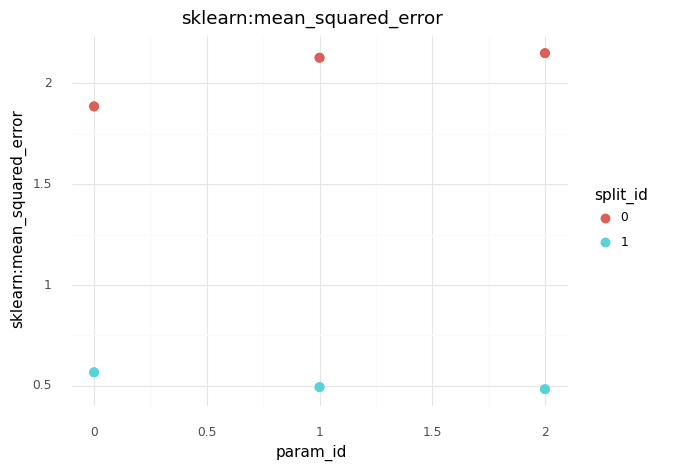

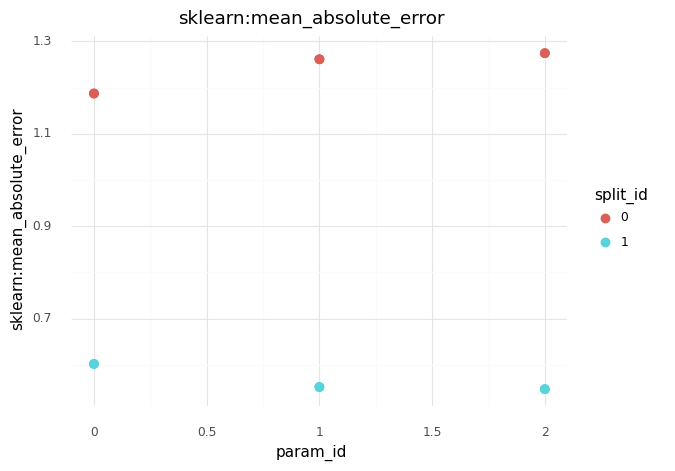

In [22]:
for metric in config['validation']['evalulation']['metrics']:
    print(plot_cv_plot(df = evaldf, metric_name = metric))